# Import libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'
PATH_COVID = '/media/maria/2TB Monster driv/PrecisionFDA/LightGBM/COVID/'

# Read train and test data

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
train.shape

(117959, 945)

In [4]:
nocovid  = pd.read_csv(PATH_COVID + 'no_covid_predicted.csv')

In [5]:
train = train.loc[train.COVID_Status == 1]
train.shape

(73697, 945)

In [6]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [7]:
train['Hospitalized'].sum()

20393.0

In [8]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  73697.0   73697.0  73697.000000  73697.000000         7.369700e+04   
mean       1.0       1.0     42.276641    -71.355158         9.958533e+05   
std        0.0       0.0      0.280952      0.594560         5.257319e+05   
min        1.0       1.0     41.241591    -73.490615         4.391440e+03   
25%        1.0       1.0     42.126691    -71.537896         6.186478e+05   
50%        1.0       1.0     42.316542    -71.153067         1.078231e+06   
75%        1.0       1.0     42.455546    -71.022418         1.440909e+06   
max        1.0       1.0     42.900027    -69.921561         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         7.369700e+04  73697.000000           7545.000000   
mean          2.272775e+04     53.953974              0.190192   
std           5.957766e+04     18.640218              0.392479   
min           0.000000e+00     21.000000              0.000000   
25%           5.048600e+03     38.000000              0.000000   
50%           8.902250e+03     55.000000              0.000000   
75%           1.581682e+04     70.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               7545.000000      7545.000000      7545.000000   
mean                   0.038436         0.046918         0.183035   
std                    0.192259         0.211478         0.386721   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              7545.000000       7545.000000     7545.000000   
mean                  0.278330          0.381975        0.180517   
std                   0.448206          0.485903        0.384643   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         7545.000000      7545.000000             7545.000000   
mean             0.196024         0.017097                0.271040   
std              0.397013         0.129643                0.444526   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       7545.000000              7545.000000              7545.000000   
mean           0.043738                 0.353612                 0.268257   
std            0.204524                 0.478122                 0.443082   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    7545.000000        7545.000000                    67162.000000   
mean    

# Hyperparameters for LightGBM

In [9]:
seed = 42
#Using the parameters from a similar project on ICU mortality 

param = {'num_leaves': 15,
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'colsample_bytree':0.6189140385454879,
        'max_child_samples': 254,
        'min_child_weight': 0.001,
        'subsample': 0.7098267979279573,
        'reg_alpha': 5, 
        'reg_lambda': 1, 
        'scale_pos_weight': 2,
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'binary',  
        'verbose': 1,
        'metric': {'binary_logloss', 'auc'},
        'is_unbalance': False, 
        'boost_from_average': True,
        'extra_trees': True
    }

In [10]:
##concatenate train and test to get dummies and not get error
#train['is_train'] = 1
#test['is_train'] = 0
#train_test = pd.concat([train, test], axis = 0)
#display_all(train_test.head())

In [11]:
train.drop(columns=['COVID_Status', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 'Days_hospitalized', 'Days_ICU'], inplace=True)  

In [12]:
predictors_int = list(train.columns)

In [13]:
cat_names = ['MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [14]:
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')
predictors_int.remove('Death')

In [15]:
#Concatenate train and test to not get error when creating dummies or missing data
train['is_train'] = 1
test['is_train'] = 0
train_test = pd.concat([train, test], axis = 0, sort=False)


In [16]:
train_test.shape

(103189, 940)

#Lightgbm handling of missing

for column in predictors_int:
    if pd.isna(train_test[column]).sum() >0:
        train_test[column + 'is_missing'] = pd.isna(train_test[column])
        train_test.loc[pd.isna(train_test[column]), column] = train[column].median() 
        #fill only with the median of train data

In [17]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [18]:
train = train_test.loc[train_test.is_train==1]
test = train_test.loc[train_test.is_train==0]

In [19]:
train.shape

(73697, 997)

In [20]:
train.drop(columns=['is_train'], inplace=True)

/home/maria/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
test.drop(columns=['is_train', 'Id'], inplace=True)

/home/maria/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
predictors = list(train.columns)
predictors.remove('Death')
predictors.remove('Id')

# LightGBM Model

In [23]:
nfold = 5
target = 'Death' 
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [24]:
len(oof)

73697

In [25]:

i = 1

for train_index, valid_index in skf.split(train, train.Death.values):
    print("\nfold {}".format(i))
    print(len(valid_index))
    
    #Train data
    t=train.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train.iloc[valid_index][predictors].values,
                           label=train.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 2000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100) #1000
    oof[valid_index] = clf.predict(train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    predictions += clf.predict(test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
14740
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1081]	training's auc: 0.886047	training's binary_logloss: 0.194258	valid_1's auc: 0.852369	valid_1's binary_logloss: 0.208317

fold 2
14740
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[866]	training's auc: 0.878057	training's binary_logloss: 0.199492	valid_1's auc: 0.864354	valid_1's binary_logloss: 0.204723

fold 3
14739
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1063]	training's auc: 0.885339	training's binary_logloss: 0.194222	valid_1's auc: 0.853259	valid_1's binary_logloss: 0.211136

fold 4
14739
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1678]	training's auc: 0.897005	training's binary_logloss: 0.186972	valid_1's auc: 0.863521	valid_1's binary_logloss: 0.206942

fold 5
14739
Training until validation score

# Metrics Analysis

In [26]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train.Death.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train.Death.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train.Death.values.astype(bool), oof) -1))



CV AUC: 0.85728


CV log loss: 0.20809


CV Gini: 0.71457


In [27]:
maximum = 0
for i in range(1000):
    f1 = metrics.f1_score(train.Death.values.astype(bool), oof >i*.001)
    if f1 > maximum:
        maximum=f1
        threshold =  i*0.001

print(f'Maximum f1 value: {maximum}' , f'Probability cutoff: {threshold}' )

Maximum f1 value: 0.42031999999999997 Probability cutoff: 0.335


In [28]:
print(metrics.classification_report(train.Death.values.astype(bool), oof >threshold))

              precision    recall  f1-score   support

       False       0.96      0.94      0.95     68129
        True       0.38      0.47      0.42      5568

    accuracy                           0.90     73697
   macro avg       0.67      0.70      0.68     73697
weighted avg       0.91      0.90      0.91     73697



# Save Predictions and OOF

In [29]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["Death"] = predictions


In [30]:
nocovid["COVID_flag"] = 0

In [31]:
sub_df = sub_df.merge(nocovid, how='left', left_on ='Id', right_on ='Id')
sub_df['COVID_flag'] = sub_df['COVID_flag'].fillna(1)

In [32]:
sub_df["Death"] = sub_df["Death"] * sub_df['COVID_flag']

In [ ]:
#change to 1- for submission

In [33]:
sub_df[['Id', 'Death']].to_csv("lightgbm_Death.csv", index=False, line_terminator='\n', header=False)


In [34]:
np.mean(predictions)

0.20872103984237012

In [35]:
#save oof

train = pd.read_csv(PATH + 'Descriptive/train.csv')
train = train.loc[train.COVID_Status == 1]
oof_df = train[["Id", "Death"]]


In [36]:
len(oof)

73697

In [37]:
train.shape

(73697, 945)

In [38]:
oof_df["LGBM"] = oof
oof_df[:10]

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Id,Death,LGBM
3,afa2680f-7f73-46d9-b0cd-2cf3db49724b,0.0,0.021239
4,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,0.0,0.023160
5,90031c21-e8a4-416e-b60b-23e871ee62dc,0.0,0.015432
6,0ac2e031-ab88-41f9-ac5d-d7d588952222,0.0,0.015085
7,45138fb4-dc79-4aec-ba78-7a012d3edca7,0.0,0.060382
8,fba0823a-d6fc-402f-a6c3-9394f54b1870,0.0,0.014452
9,93ef4d47-2a1e-4af1-b792-96a6077b75e0,0.0,0.016126
10,ff524e84-ef48-4c59-8e16-ff28514271a1,0.0,0.008308
11,5c6dd9dd-effb-4ba6-a059-a60579b86ee1,0.0,0.070123
12,c58ae02e-235e-4db2-a9c3-6926e9c0c5fa,1.0,0.120779


In [39]:
oof_df.to_csv("Ooflightgbm.csv", index=False)

# Explainability

In [40]:
fpr_rf, tpr_rf, _ = roc_curve(train.Death.values.astype(bool), oof)

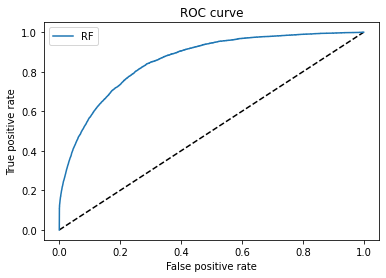

In [41]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [42]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(train.Death.values.astype(bool), oof)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.44


In [43]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [44]:
import seaborn as sns

In [45]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [46]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

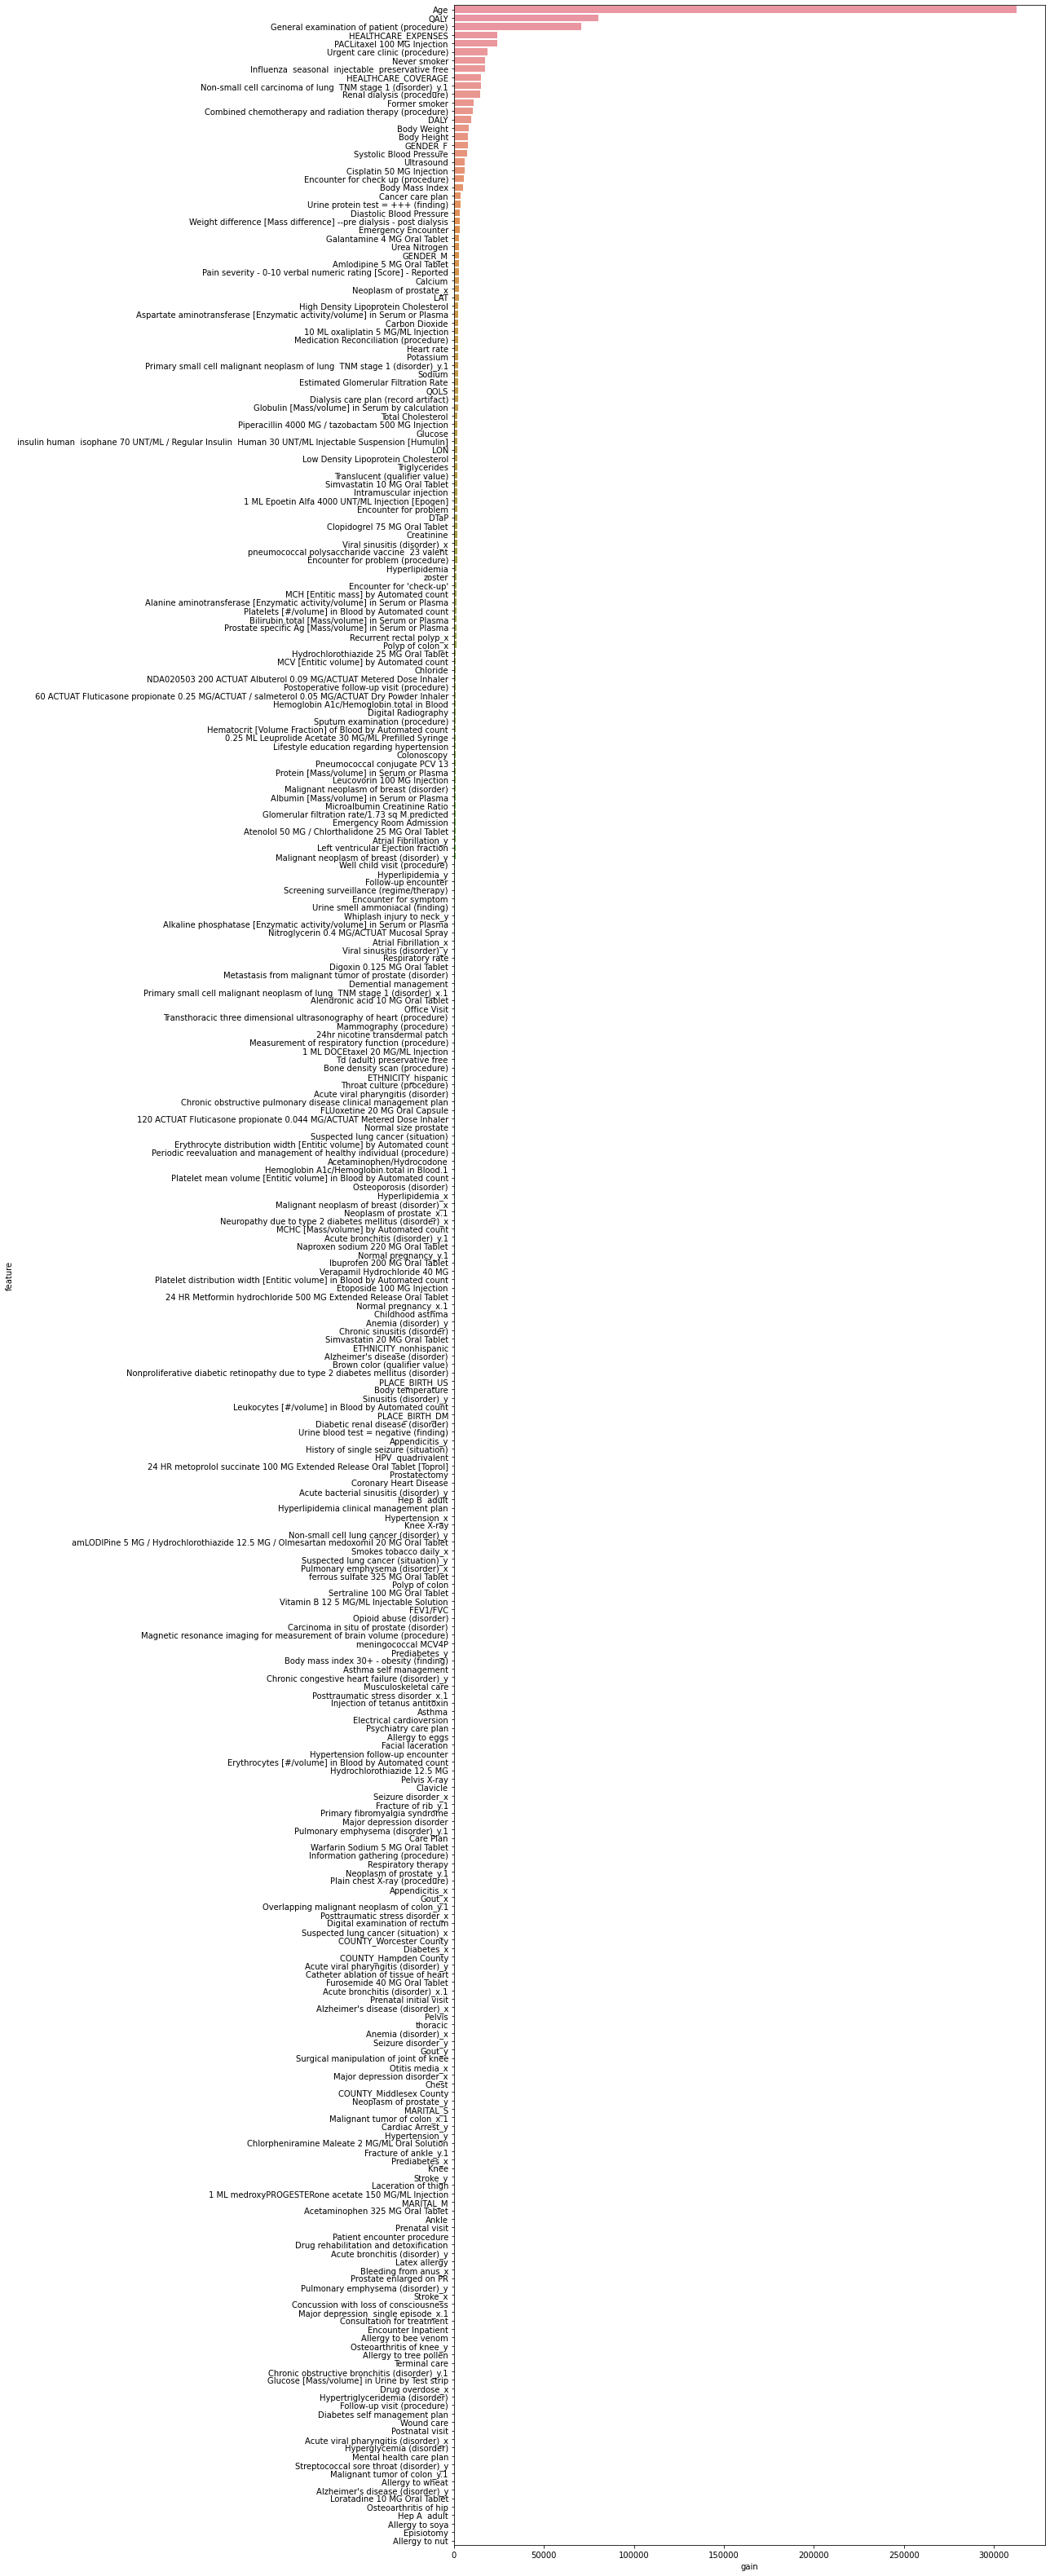

In [47]:
plot_importances(imp_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


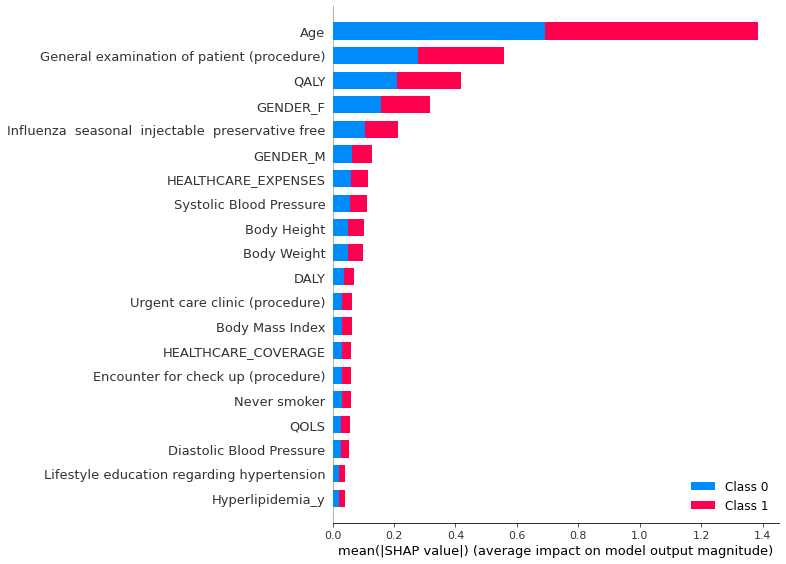

In [48]:
import shap
explainer   =  shap.TreeExplainer(clf)
shap_values = explainer.shap_values(t[predictors].iloc[:8000,:])
shap.summary_plot(shap_values, t[predictors].iloc[:8000,:])